# Artificial Intelligence Classifier
## Generative AI (GenAI) - 005

<center>
<table align="center">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/christophergarthwood/jbooks/blob/main/STEM-005_Classifier.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo"><br> Run in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/notebooks?referrer=search&hl=en&project=usfs-ai-bootcamp">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo"><br> Link to Colab Enterprise
    </a>
  </td>   
  <td style="text-align: center">
    <a href="https://github.com/christophergarthwood/jbooks/blob/main/STEM-005_CLassifier.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/instances?referrer=search&hl=en&project=usfs-ai-bootcamp">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo"><br> Link to Vertex AI Workbench
    </a>
  </td>
</table>
</center>
</br></br></br>

| | |
|-|-|
|Author(s) | [Christopher G Wood](https://github.com/christophergarthwood)  |

# Overview

Basic classification: Classify images of clothing.

Classification is the process of predicting the class of given data points. Classes are sometimes called as targets/ labels or categories. Classification predictive modeling is the task of approximating a mapping function (f) from input variables (X) to discrete output variables (y).

Said another way...

A classifier in machine learning is an algorithm that automatically orders or categorizes data into one or more of a set of “classes.” The process of categorizing or classifying information based on certain characteristics is known as classification.

For example, spam detection in email service providers can be identified as a classification problem. This is s binary classification since there are only 2 classes as spam and not spam. A classifier utilizes some training data to understand how given input variables relate to the class. In this case, known spam and non-spam emails have to be used as the training data. When the classifier is trained accurately, it can be used to detect an unknown email.

Classification belongs to the category of supervised learning where the targets also provided with the input data. There are many applications in classification in many domains such as in credit approval, medical diagnosis, target marketing etc.


Types of Classifiers:
+ Binary Classifiers: These are used when there are only two possible classes. For example, an email classifier might be designed to detect spam and non-spam emails.
+ Multiclass Classifiers: These handle situations where there are more than two classes. For instance, a classifier that categorizes news articles into topics like sports, politics, and technology.
+ Multilabel Classifiers: These can assign multiple labels to each instance. For example, a movie could be classified into multiple genres like comedy,drama, and action simultaneously.


## References:

+ https://www.tensorflow.org/tutorials/keras/classification
+ https://towardsdatascience.com/machine-learning-classifiers-a5cc4e1b0623
+ https://github.com/christophergarthwood/jbooks/blob/main/ML-000-d_KerasTensorFlowGPU.ipynb

In [1]:
# Let's define some variables (information holders) for our project overall

global PROJECT_ID, BUCKET_NAME, LOCATION
BUCKET_NAME ="cio-training-vertex-colab"
PROJECT_ID  ="usfs-ai-bootcamp"
LOCATION    = "us-central1"

BOLD_START="\033[1m"
BOLD_END="\033[0m"

In [2]:
# Now create a means of enforcing project id selection

import ipywidgets as widgets
from IPython.display import display

def wait_for_button_press():

    button_pressed = False

    # Create widgets
    html_widget = widgets.HTML(

    value="""
        <center><table><tr><td><h1 style="font-family: Roboto;font-size: 24px"><b>&#128721; &#9888;&#65039; WARNING &#9888;&#65039;	&#128721; </b></h1></td></tr></table</center></br></br>

        <table><tr><td>
            <span style="font-family: Tahoma;font-size: 18">
              This notebook was designed to work in Jupyter Notebook or Google Colab with the understnading that certain permissions might be enabled.</br>
              Please verify that you are in the appropriate project and that the:</br>
              <center><code><b>PROJECT_ID</b></code> </br></center>
              aligns with the Project Id in the upper left corner of this browser and that the location:
              <center><code><b>LOCATION</b></code> </br></center>
              aligns with the instructions provided.
            </span>
          </td></tr></table></br></br>

    """)

    project_list=["usfs-ai-bootcamp", "usfa-ai-advanced-training", "I will setup my own"]
    dropdown = widgets.Dropdown(
        options=project_list,
        value=project_list[0],
        description='Set Your Project:',
    )

    html_widget2 = widgets.HTML(
    value="""
        <center><table><tr><td><h1 style="font-family: Roboto;font-size: 24px"><b>&#128721; &#9888;&#65039; WARNING &#9888;&#65039;	&#128721; </b></h1></td></tr></table</center></br></br>
          """)

    button = widgets.Button(description="Accept")

    # Function to handle the selection change
    def on_change(change):
        global PROJECT_ID
        if change['type'] == 'change' and change['name'] == 'value':
            #print("Selected option:", change['new'])
            PROJECT_ID=change['new']

    # Observe the dropdown for changes
    dropdown.observe(on_change)

    def on_button_click(b):
        nonlocal button_pressed
        global PROJECT_ID
        button_pressed = True
        #button.disabled = True
        button.close()  # Remove the button from display
        with output:
          #print(f"Button pressed...continuing")
          #print(f"Selected option: {dropdown.value}")
          PROJECT_ID=dropdown.value

    button.on_click(on_button_click)
    output = widgets.Output()

    # Create centered layout
    centered_layout = widgets.VBox([
                                    html_widget,
                                    widgets.HBox([dropdown, button]),
                                    html_widget2,
    ], layout=widgets.Layout(
                              display='flex',
                              flex_flow='column',
                              align_items='center',
                              width='100%'
    ))
    # Display the layout
    display(centered_layout)


wait_for_button_press()

## Environment

In [3]:
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#- Google Colab Check
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
import datetime

RunningInCOLAB = False
RunningInCOLAB = 'google.colab' in str(get_ipython())
current_time   = datetime.datetime.now()

if RunningInCOLAB:
    print(f"You are running this notebook in Google Colab at {current_time} in the {PROJECT_ID} lab.")
else:
    print(f"You are likely running this notebook with Jupyter iPython runtime at {current_time} in the {PROJECT_ID} lab.")

You are running this notebook in Google Colab at 2025-01-23 20:05:03.781581 in the usfs-ai-bootcamp lab.


## Library Management

In [4]:
# Import key libraries necessary to support dynamic installation of additional libraries
import sys
# Use subprocess to support running operating system commands from the program, using the "bang" (!)
# symbology is supported, however that does not translate to an actual python script, this is a more
# agnostic approach.
import subprocess
import importlib.util

In [5]:
# Identify the libraries you'd like to add to this Runtime environment.
libraries=["backoff", "nltk", "bs4", "wordcloud", "pathlib", "numpy", "Pillow", "pandas",
           "python-dotenv", "seaborn", "rich", "rich[jupyter]", "piexif", "PyMuPDF","unidecode",
           "spacy", "gensim", "cluestar", "watermark", "watermark[GPU]", "scattertext",]

# Loop through each library and test for existence, if not present install quietly
for library in libraries:
    if library == "Pillow":
      spec = importlib.util.find_spec("PIL")
    else:
      spec = importlib.util.find_spec(library)
    if spec is None:
      print("Installing library " + library)
      subprocess.run(["pip", "install" , library, "--quiet"], check=True)
    else:
      print("Library " + library + " already installed.")

Library backoff already installed.
Library nltk already installed.
Library bs4 already installed.
Library wordcloud already installed.
Library pathlib already installed.
Library numpy already installed.
Library Pillow already installed.
Library pandas already installed.
Installing library python-dotenv
Library seaborn already installed.
Library rich already installed.
Installing library rich[jupyter]
Library piexif already installed.
Installing library PyMuPDF
Library unidecode already installed.
Library spacy already installed.
Library gensim already installed.
Library cluestar already installed.
Library watermark already installed.
Installing library watermark[GPU]
Library scattertext already installed.


## Libraries

In [6]:
#- Import additional libraries that add value to the project related to NLP

# Beautiful Soup (BS4) is used to parse HTML documents.
from bs4 import BeautifulSoup

# Word cloud building library
from wordcloud import WordCloud, STOPWORDS

#- Set of libraries that perhaps should always be in Python source
import backoff
import datetime
from dotenv import load_dotenv
import gc
import getopt
import glob
import inspect
import io
import itertools
import json
import math
import os
from pathlib import Path
import pickle
import platform
import random
import re
import shutil
import string
from io import StringIO
import subprocess
import socket
import sys
import textwrap
import tqdm
import traceback
import warnings
import time
from time import perf_counter
from rich import print as rprint
from rich.console import Console
from rich.traceback import install
import locale

#- Displays system info
from watermark import watermark as the_watermark
from py3nvml import py3nvml

#- Additional libraries for this work
import math
from base64 import b64decode
from IPython.display import Image, Markdown
import pandas, IPython.display as display, io, jinja2, base64
import requests
import unidecode

#- Data Science Libraries
import numpy as np
import pandas as pd
import seaborn as sns

#- Graphics
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.cbook import get_sample_data
from matplotlib.offsetbox import (AnnotationBbox, DrawingArea, OffsetImage,
                                  TextArea)
from matplotlib.pyplot import imshow
from matplotlib.patches import Circle
from PIL import Image as PIL_Image
import PIL.ImageOps

#- Image meta-data for Section 508 compliance
import piexif
from piexif.helper import UserComment


#- Progress bar
from tqdm import tqdm

# ML Libs
import tensorflow as tf
from keras.datasets import mnist

## Application Variables

In [7]:
# Versioning
VERSION_NAME    = "MLCLASSIFIER"
VERSION_MAJOR   = 0
VERSION_MINOR   = 0
VERSION_RELEASE = 1

# API Parameters for things like WordCloud, variables help hold information for later use
# The "constants" represent variables that we don't anticipate changing over the course of the program.
IMG_BACKGROUND="black"     #options are black, white, another color or None
IMG_FONT_SIZE_MIN=10
IMG_WIDTH=1024
IMG_HEIGHT=768
IMG_INTERP="bilinear"
IMG_ALPHA=0.8
IMG_ASPECT="equal"
FIGURE_WIDTH=11
FIGURE_HEIGHT=8.5
WORD_FREQ=10

# specify how image formats will be saved
IMG_EXT=".jpg"

# used to fully display the error stack, set to 1 if you want to see a ridiculous amount of debugging information
DEBUG_STACKTRACE=0

# location of our working files
WORKING_FOLDER="/content/folderOnColab"

# Notebook Author details
AUTHOR_NAME="Christopher G Wood"
GITHUB_USERNAME="christophergarthwood"
AUTHOR_EMAIL="christopher.g.wood@gmail.com"

# GenAI
BUFFER_SIZE = 60000
BATCH_SIZE = 256
TEXT_WIDTH=77
IMG_SCALE=0.75

BUFFER_SIZE = 60000
BATCH_SIZE = 256


# Encoding
ENCODING  ="utf-8"
os.environ['PYTHONIOENCODING']=ENCODING


## Function

In [8]:
# Functions are like legos that do one thing, this function outputs library version history of effort.
def lib_diagnostics() -> None:

    import pkg_resources

    package_name_length=20
    package_version_length=10

    # Show notebook details
    #%watermark?
    #%watermark --github_username christophergwood --email christopher.g.wood@gmail.com --date --time --iso8601 --updated --python --conda --hostname --machine --githash --gitrepo --gitbranch --iversions --gpu
    # Watermark
    rprint(the_watermark(author=f"{AUTHOR_NAME}", github_username=f"GITHUB_USERNAME", email=f"{AUTHOR_EMAIL}",iso8601=True, datename=True, current_time=True, python=True, updated=True, hostname=True, machine=True, gitrepo=True, gitbranch=True, githash=True))


    print(f"{BOLD_START}Packages:{BOLD_END}")
    print("")
    # Get installed packages
    the_packages=["nltk", "numpy", "os", "pandas", "seaborn"]
    installed = {pkg.key: pkg.version for pkg in pkg_resources.working_set}
    for package_idx, package_name in enumerate(installed):
         if package_name in the_packages:
             installed_version = installed[package_name]
             rprint(f"{package_name:<40}#: {str(pkg_resources.parse_version(installed_version)):<20}")

    try:
        rprint(f"{'TensorFlow version':<40}#: {str(tf.__version__):<20}")
        rprint(f"{'     gpu.count:':<40}#: {str(len(tf.config.experimental.list_physical_devices('GPU')))}")
        rprint(f"{'     cpu.count:':<40}#: {str(len(tf.config.experimental.list_physical_devices('CPU')))}")
    except Exception as e:
        pass

    try:
        rprint(f"{'Torch version':<40}#: {str(torch.__version__):<20}")
        rprint(f"{'     GPUs available?':<40}#: {torch.cuda.is_available()}")
        rprint(f"{'     count':<40}#: {torch.cuda.device_count()}")
        rprint(f"{'     current':<40}#: {torch.cuda.current_device()}")
    except Exception as e:
        pass


    try:
      print(f"{'OpenAI Azure Version':<40}#: {str(the_openai_version):<20}")
    except Exception as e:
      pass

    return

In [9]:
# Routines designed to support adding ALT text to an image generated through Matplotlib.

def capture(figure):
   buffer = io.BytesIO()
   figure.savefig(buffer)
   #return F"data:image/png;base64,{base64.b64encode(buffer.getvalue()).decode()}"
   return F"data:image/jpg;base64,{base64.b64encode(buffer.getvalue()).decode()}"

def make_accessible(figure, template, **kwargs):
   return display.Markdown(F"""![]({capture(figure)} "{template.render(**globals(), **kwargs)}")""")


# requires JPG's or TIFFs
def add_alt_text(image_path, alt_text):
    try:
        if os.path.isfile(image_path):
          img = PIL_Image.open(image_path)
          if "exif" in img.info:
              exif_dict = piexif.load(img.info["exif"])
          else:
              exif_dict={}

          w, h = img.size
          if "0th" not in exif_dict:
            exif_dict["0th"]={}
          exif_dict["0th"][piexif.ImageIFD.XResolution] = (w, 1)
          exif_dict["0th"][piexif.ImageIFD.YResolution] = (h, 1)

          software_version=" ".join(["STEM-001 with Python v", str(sys.version).split(" ")[0]])
          exif_dict["0th"][piexif.ImageIFD.Software]=software_version.encode("utf-8")

          if "Exif" not in exif_dict:
            exif_dict["Exif"]={}
          exif_dict["Exif"][piexif.ExifIFD.UserComment] = UserComment.dump(alt_text, encoding="unicode")

          exif_bytes = piexif.dump(exif_dict)
          img.save(image_path, "jpeg", exif=exif_bytes)
        else:
          rprint(f"Cound not fine {image_path} for ALT text modification, please check your paths.")

    except (FileExistsError, FileNotFoundError, Exception) as e:
        process_exception(e)

# Appears to solve a problem associated with GPU use on Colab, see: https://github.com/explosion/spaCy/issues/11909
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"

In [10]:
# this function displays the stack trace on errors from a central location making adjustments to the display on an error easier to manage
# functions perform useful solutions for highly repetitive code
def process_exception(inc_exception: Exception) -> None:
  if DEBUG_STACKTRACE==1:
    traceback.print_exc()
    console.print_exception(show_locals=True)
  else:
    rprint(repr(inc_exception))

## Setup Instances of Variables for System Configuration and Library Instantiation

In [11]:
# Setup the rich print console for future use
if DEBUG_STACKTRACE==1:
  console = Console()

# Use the 'Agg' backend for non-interactive environments
#matplotlib.use('Agg')

# Ensure UTF-8 Encoding is set
locale.getpreferredencoding = getpreferredencoding

## Function Call

In [12]:
# Now call the function just created and get input on what versions of software we're using.
lib_diagnostics()

<ipython-input-8-2dfa354ae58a>:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


Author: Christopher G Wood

Github username: GITHUB_USERNAME

Email: christopher.g.wood@gmail.com

Last updated: 2025-01-23T20:05:28.365620+00:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 5.15.167+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

Hostname: 685e589de4dd

Git hash: 

Git repo: 

Git branch:

Packages:



nltk                                    #: 3.9.1

numpy                                   #: 1.26.4

pandas                                  #: 2.2.2

seaborn                                 #: 0.13.2

TensorFlow version                      #: 2.17.1

gpu.count:                         #: 1

cpu.count:                         #: 1

## Input Sources

### Load and prepare the dataset

You will use the MNIST dataset to obtain data.

*Note*:
MNIST database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems.  Reference: https://en.wikipedia.org/wiki/MNIST_database

This example uses the Fashion MNIST: https://github.com/zalandoresearch/fashion-mnist

Fashion MNIST is intended as a drop-in replacement for the classic MNIST dataset—often used as the "Hello, World" of machine learning programs for computer vision. The MNIST dataset contains images of handwritten digits (0, 1, 2, etc.) in a format identical to that of the articles of clothing you'll use here.

This guide uses Fashion MNIST for variety, and because it's a slightly more challenging problem than regular MNIST. Both datasets are relatively small and are used to verify that an algorithm works as expected. They're good starting points to test and debug code.

Here, 60,000 images are used to train the network and 10,000 images to evaluate how accurately the network learned to classify images. You can access the Fashion MNIST directly from TensorFlow.

In [13]:
# Create the folder that will hold our content.
target_folder=WORKING_FOLDER
rprint(f"Creating a folder ({target_folder}) to store project data.")

try:
  if os.path.isfile(target_folder):
    raise OSError("Cannot create your folder a file of the same name already exists there, work with your instructor or remove it yourself.")
  elif os.path.isdir(target_folder):
    print(f"The folder named ({target_folder}) {BOLD_START}already exists{BOLD_END}, we won't try to create a new folder.")
  else:
    subprocess.run(["mkdir", "-p" , target_folder], check=True)
except (subprocess.CalledProcessError, Exception) as e:
  process_exception(e)

Creating a folder (/content/folderOnColab) to store project data.

The folder named (/content/folderOnColab) already exists, we won't try to create a new folder.


In [14]:
#create reference to dataset
fashion_mnist = tf.keras.datasets.fashion_mnist

#load the data and split into train/test datasets
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [15]:
#Train variable details
print(f"Your {BOLD_START}training data{BOLD_END}:")
rprint("{} shape is {}.".format("Train images ", train_images.shape) )
rprint("{} shape is {}.".format("Train labels ", train_labels.shape) )
rprint("{} sample structure is {}".format("Train labels", train_labels))
rprint("These images and thier corresponding labels represent trusted data to train the model on.")
print("")
print("")

#Test variable details
print(f"Your {BOLD_START}testing data{BOLD_END}:")
rprint("{} shape is {}.".format("Test images ", test_images.shape) )
rprint("{} shape is {}.".format("Test labels ", test_labels.shape) )
rprint("{} sample structure is {}".format("Test labels", test_labels))
rprint("These images and thier corresponding labels represent trusted data to test the model on.  How does the model know if it's performing well?")
rprint("By using the test data per iteration to check itself.")

Your training data:


Train images  shape is (60000, 28, 28).

Train labels  shape is (60000,).

Train labels sample structure is [9 0 0 ... 3 0 5]

These images and thier corresponding labels represent trusted data to train the model on.



Your testing data:


Test images  shape is (10000, 28, 28).

Test labels  shape is (10000,).

Test labels sample structure is [9 2 1 ... 8 1 5]

These images and thier corresponding labels represent trusted data to test the model on.  How does the model know 
if it's performing well?

By using the test data per iteration to check itself.

### Dataset Definition

The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255. The labels are an array of integers, ranging from 0 to 9. These correspond to the class of clothing the image represents:

Label 	Class

+ 0 	T-shirt/top
+ 1 	Trouser
+ 2 	Pullover
+ 3 	Dress
+ 4 	Coat
+ 5 	Sandal
+ 6 	Shirt
+ 7 	Sneaker
+ 8 	Bag
+ 9 	Ankle boot

Each image is mapped to a single label. Since the class names are not included with the dataset, store them here to use later when plotting the images:

In [16]:
#associate "human legible" labels to the actual dataset
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## Example Image from Dataset

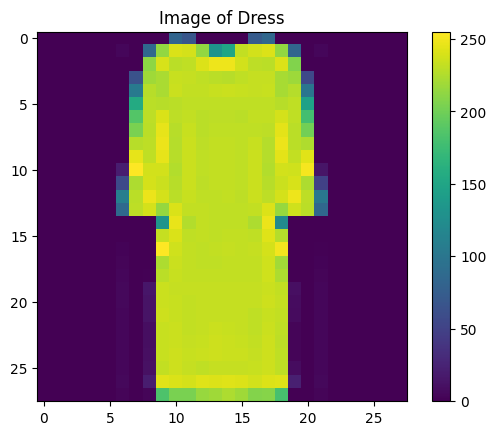

28 x 28 image from the training dataset representing a Dress, random number is 44814.

In [17]:
# Create a random number to pull an image from the training dataset, let's make sure we're getting what's expected.
import random
x = random.randint(0,train_labels.shape[0])

# Show the first image from the training dataset
caption_text=f"28 x 28 image from the training dataset representing a {class_names[train_labels[x]]}, random number is {x}."

plt.figure()
plt.title(f"Image of {class_names[train_labels[x]]}")
plt.imshow(train_images[x])
plt.colorbar()
plt.grid(False)
plt.show()
rprint(caption_text)
plt.close()

## Preprocess the data

Deep learning neural networks learn how to map inputs to outputs from examples in a training dataset.

The weights of the model are initialized to small random values and updated via an optimization algorithm in response to estimates of error on the training dataset.

Given the use of small weights in the model and the use of error between predictions and expected values, the scale of inputs and outputs used to train the model are an important factor. Unscaled input variables can result in a slow or unstable learning process, whereas unscaled target variables on regression problems can result in exploding gradients causing the learning process to fail.

Data preparation involves using techniques such as the normalization and standardization to rescale input and output variables prior to training a neural network model.

The data must be preprocessed before training the network. If you inspect the first image in the training set, you will see that the pixel values fall in the range of 0 to 255.

Scale these values to a range of 0 to 1 before feeding them to the neural network model. To do so, divide the values by 255. It's important that the training set and the testing set be preprocessed in the same way.  Ultimately your inference / prediction of data will follow the same method of scaling.

If you don't make your inference inputs align to the same method(s) you used during training, you cannot expect the same level of quality result obtained during training.

**Reference**: https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/

In [18]:
# scale the images between 0 - 1
train_images = train_images / 255.0
test_images = test_images / 255.0

## Show Sample Data
Show the first 25 images from the training dataset and display the classification name with each.

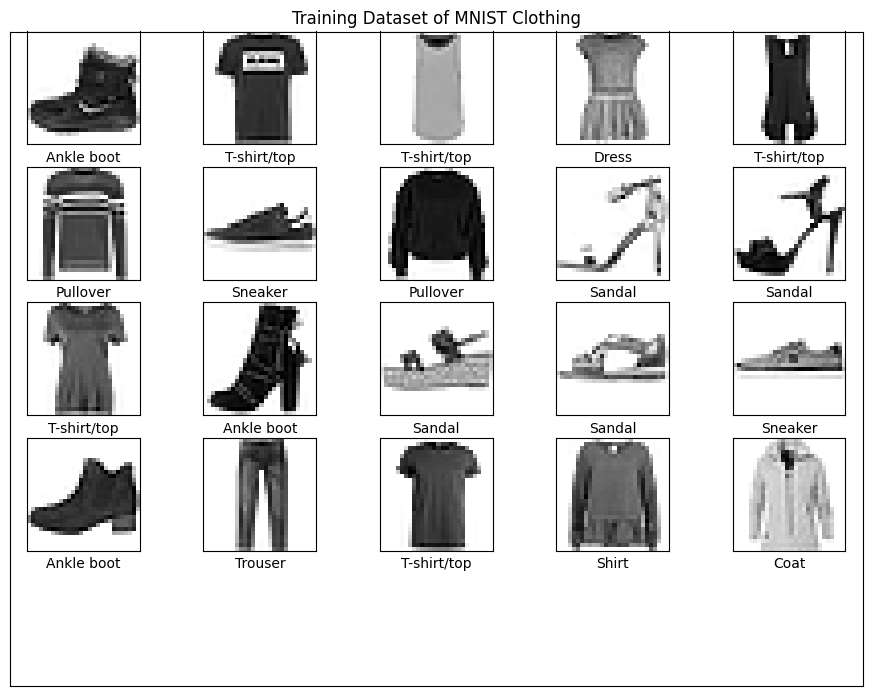

28 x 28 image from the training dataset representing a: Ankle boot, T-shirt/top, T-shirt/top, Dress, T-shirt/top, 
Pullover, Sneaker, Pullover, Sandal, Sandal, T-shirt/top, Ankle boot, Sandal, Sandal, Sneaker, Ankle boot, Trouser,
T-shirt/top, Shirt, Coat  as seen from top to bottom, left to right.

In [19]:
# Verification of dataset.
# Did you notice a difference in the output of the data?  What's the difference between the first image seen and these images?

IMG_TO_SHOW=20

caption_start=f"28 x 28 image from the training dataset representing a:"
caption_end = " as seen from top to bottom, left to right."
the_labels=[]
for idx in range(IMG_TO_SHOW):
    the_labels.append(class_names[train_labels[idx]])
caption_labels=", ".join(the_labels)
caption_text = " ".join([caption_start, caption_labels, caption_end])


plt.figure(figsize=(FIGURE_WIDTH,FIGURE_HEIGHT))
plt.title("Training Dataset of MNIST Clothing")
plt.xticks([])
plt.yticks([])
for i in range(IMG_TO_SHOW):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
target_filename=target_folder+os.sep+f"STEM-005_MNIST_Clothing_Normalized_TrainingData{IMG_EXT}";
plt.savefig(target_filename);
plt.show()
print("")
rprint(caption_text)


## Before we start...

*Let's talk about CPU versus GPU.*

A central processing unit (CPU) and a graphics processing unit (GPU) are both essential components of a computer, but they have different functions and architectures:

### CPU

The CPU is the core of a computer's processing system and is responsible for handling all the computing tasks that allow the operating system and applications to run. CPUs are often referred to as the "brain" of the computer and are well suited to a wide range of tasks.

### GPU

GPUs are considered superior for Artificial Intelligence and Machine Learning (AIML) because of their unique architecture designed for parallel processing, allowing them to perform a large number of calculations simultaneously, which is ideal for the complex mathematical operations involved in training and running AI models, especially when dealing with large datasets; essentially, GPUs can process massive amounts of data much faster than CPUs due to their numerous cores optimized for parallel computations.

Here are some other differences between CPUs and GPUs:

+ Parallel Processing:
GPUs have thousands of smaller cores that can handle multiple calculations simultaneously, making them perfect for tasks that involve repetitive operations on large datasets, like matrix multiplications used in neural networks.

+ High Memory Bandwidth:
GPUs have dedicated high-speed memory (like GDDR6) which allows for rapid data transfer between the processing cores, crucial for feeding large amounts of data efficiently.

+ Optimized for AI Frameworks:
Major GPU manufacturers like NVIDIA have developed specialized libraries and frameworks (like CUDA) that are highly optimized for AI workloads, further accelerating performance.

+Faster Training Time:
By leveraging parallel processing, GPUs significantly reduce the time needed to train complex AI models, enabling faster iteration and experimentation.

***If the only thing you remember is this then you're okay...ALWAYS try to utilize the GPU and make sure you're actually using it.***

**Reference:** https://blogs.nvidia.com/blog/why-gpus-are-great-for-ai/

In [20]:
# Setup some basic timers material
from time import perf_counter

## Let's see what we've got...

In [21]:
print(f"{BOLD_START}List Devices{BOLD_END} #########################################")
try:
  from tensorflow.python.client import device_lib
  rprint(device_lib.list_local_devices())
  print("")
except RuntimeError as e:
  # Visible devices must be set before GPUs have been initialized
  rprint(str(repr(e)))

print(f"{BOLD_START}Devices Counts{BOLD_END} ########################################")
try:
  rprint(f"Num GPUs Available: {str(len(tf.config.experimental.list_physical_devices('GPU')))}" )
  rprint(f"Num CPUs Available: {str(len(tf.config.experimental.list_physical_devices('CPU')))}" )
  print("")
except RuntimeError as e:
  # Visible devices must be set before GPUs have been initialized
  rprint(str(repr(e)))

print(f"{BOLD_START}Optional Enablement{BOLD_END} ####################################")
try:
  gpus = tf.config.experimental.list_physical_devices('GPU')
except RuntimeError as e:
  # Visible devices must be set before GPUs have been initialized
  rprint(str(repr(e)))

if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    rprint( str( str(len(gpus)) + " Physical GPUs," + str(len(logical_gpus)) + " Logical GPU") )
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    rprint(str(repr(e)))
  print("")


List Devices #########################################


[
    name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2756375805709641751
xla_global_id: -1
,
    name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14431289344
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17369786163991630859
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419

]


Devices Counts ########################################


Num GPUs Available: 1

Num CPUs Available: 1


Optional Enablement ####################################


1 Physical GPUs,1 Logical GPU

## Set logging constructs and use the OS environment to control access to hardware

TensorFlow uses the standard Python logging levels, which are:

+ DEBUG: Detailed information, typically only useful for debugging.

+ INFO: General information about the progress of the program.

+ WARN: Warnings about potential issues that may not cause the program to fail.

+ ERROR: Errors that prevent the program from continuing.

+ FATAL: Critical errors that cause the program to terminate immediately.

How to control logging levels:

**TF_CPP_MIN_LOG_LEVEL** environment variable: This variable controls the minimum log level for TensorFlow's C++ backend.

+ 0: Log all messages.
+ 1: Log all messages except INFO.
+ 2: Log all messages except INFO and WARNING (default).
+3: Log all messages except INFO, WARNING, and ERROR.

In [22]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '10'
#To disable GPU access to the current runtime enable -1 for "no GPUs"
#confirmed to work on the Command Line Interface (CLI) of all systems but this one...

#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

## Now Train on CPU only

## Build the model

Building the neural network requires configuring the layers of the model, then compiling the model.

### Set up the layers

The basic building block of a neural network is the layer. Layers extract representations from the data fed into them.

Most of deep learning consists of chaining together simple layers. Most layers, such as tf.keras.layers.Dense, have parameters that are learned during training.

Rectified linear unit (ReLU), is an activation function which means, this is how the neuron determines if it's going to fire (weighting of probabilities). See: https://en.wikipedia.org/wiki/Rectifier_(neural_networks) The short version is that ReLU is considered an excellent tool and using a vanishing gradient to determine probabilities always making sure any value less than zero is set to 0.

Your output layer must equal the number of questions you're seeking to ask.  In this case we have ten (10) categories of clothing so we need 10 neurons to represent those different potential answers.

Notice that the "shape" of the first layer corresponds to the shape of the input image.

In [24]:
# Given the images and labels begin learning from the train_* dataset for multiple "iterations".
# Note that you are ACTIVELY training a neural layer (AI) solution now.

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'
start_t=perf_counter()

try:
  # by using "with" you assign the memory and processing to that device
  with tf.device('/job:localhost/replica:0/task:0/device:CPU:0'):

    #DESIGN/BUILD
    #capture the function calls return into a variable, this encapsulate a complex object that defines the entire neural model
    model = tf.keras.Sequential([
        #one-D array are preferred for all processing
        #The first layer in this network, tf.keras.layers.Flatten, transforms the format of the images from a two-dimensional array
        #(of 28 by 28 pixels) to a one-dimensional array (of 28 * 28 = 784 pixels). Think of this layer as unstacking rows of pixels
        #in the image and lining them up. This layer has no parameters to learn; it only reformats the data.
        tf.keras.layers.Flatten(input_shape=(28, 28)),

        #first layer is 128 neurons and a ReLU activation function.
        tf.keras.layers.Dense(128, activation='relu'),

        #output layer defined
        tf.keras.layers.Dense(10)
    ])

    #COMPILE
    model.compile(optimizer='adam',
              #v2.1 accepts this activation method but previous versions DO NOT
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

    #FIT/TRAIN
    model.fit(train_images, train_labels, epochs=10)
except RuntimeError as e:
  print(str(repr(e)))


end_t=perf_counter()
print(f"Elapsed time: {end_t - start_t}")



/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7840 - loss: 0.6256
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8581 - loss: 0.3862
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8758 - loss: 0.3367
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8864 - loss: 0.3103
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8934 - loss: 0.2885
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8983 - loss: 0.2727
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9020 - loss: 0.2641
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9049 - loss: 0.2535
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9110 - loss: 0.2389
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9138 - loss: 0.2302
Elapsed time: 33.07897764199879


## Compile the model

Before the model is ready for training, it needs a few more settings. These are added during the model's compile step:

+ Loss function —This measures how accurate the model is during training. You want to minimize this function to "steer" the model in the right direction.

+ Optimizer —This is how the model is updated based on the data it sees and its loss function.

+ Metrics —Used to monitor the training and testing steps. The following example uses accuracy, the fraction of the images that are correctly classified.

### Loss Functions

In artificial intelligence (AI), a "loss function" is a mathematical function that measures the difference between a model's predicted output and the actual target value, essentially quantifying how "wrong" the model's prediction is; the goal during training is to minimize this loss value by adjusting the model's parameters to improve its accuracy on the data.

Examples of common loss functions:

+ Mean Squared Error (MSE):
Used in regression tasks, calculates the average squared difference between predicted and actual values.

+ Cross-Entropy Loss:
Commonly used in classification problems, measures the difference between the model's predicted probability distribution and the true class distribution.

+ Hinge Loss:
Often used in support vector machines (SVMs), penalizes predictions that are not sufficiently far from the correct class boundary.

How loss functions work in practice:

+ Prediction: The model makes a prediction on a data point.

+ Loss calculation: The loss function compares the prediction to the actual target value, calculating the error.

+Backpropagation: The calculated loss is used to adjust the model's parameters (weights) through a process called backpropagation, aiming to reduce the loss on subsequent iterations.

### Optimization Algorithms

Optimization algorithms:Optimization algorithms are a class of algorithms that are used to find the best possible solution to a given problem. The goal of an optimization algorithm is to find the optimal solution that minimizes or maximizes a given objective function. There are many different types of optimization algorithms, each with its own strengths and weaknesses. Some of the most popular optimization algorithms include gradient descent, conjugate gradient, Newton's Method, and Simulated Annealing.

Optimization algorithms are powerful tools for solving complex problems. They have the potential to revolutionize how we interact with data. The optimization process involves taking a given set of parameters and finding the optimal solution that maximizes value or minimizes cost, depending on the objective function being optimized. In this article, an overview of optimization algorithms is presented along with some examples of their application in real-world scenarios.

The power of these algorithms lies in their ability to make decisions based on accurate models and data obtained from physical experiments or simulations. This means they can be used to solve problems quickly without having to rely solely on manual processes. For example, optimization algorithms can be used to find solutions for traveling salesman problems (TSPs), which involve finding the shortest route between multiple destinations while minimizing costs associated with time, fuel consumption, etc.

In addition to TSPs, many other applications exist including scheduling tasks and resources efficiently, controlling robotic arms accurately and achieving maximum profit in manufacturing operations. Put simply, when it comes to problem-solving, optimization algorithms provide a way for us to optimize our outcomes quickly and precisely - making them invaluable assets for many different industries today.

What Is The Meaning Of Optimization Algorithm?
Optimization algorithms are powerful tools used to solve optimization problems. They can be characterized as algorithms that try to find the most efficient solution when given a set of conditions or constraints. Optimization algorithms have been employed in various fields, such as engineering and operations research. The type of algorithm used depends on the nature of the problem being solved; for example, convex optimization is suitable for continuous functions while discrete optimization may be used if an integer value is desired. Additionally, there are approximation algorithms which search for near-optimal solutions and combinatorial optimization techniques which focus on finding effective ways to combine elements from distinct sets.

Stochastic gradient descent (SGD) is one of the most popular optimization techniques because it has proven to be extremely efficient in practice and easy to implement with little computation cost. SGD works by iteratively calculating a parameter vector using data points sampled from a training dataset until convergence or maximum iterations are reached. This method guarantees high accuracy results even with limited computational resources since it only requires small adjustments at each iteration step instead of optimizing all parameters simultaneously. Furthermore, SGD performs well in presence of noisy data due to its robustness against outliers compared to other approaches like quadratic programming and trust region methods.

In summary, optimization algorithms are essential components for solving complex optimization problems efficiently with few resources required. While some techniques such as stochastic gradient descent provide fast and reliable results, others like convex optimisation require more careful analysis before use depending on the specific problem requirements. All these methods make up a comprehensive suite of options available for tackling any kind of task requiring optimal solutions quickly and reliably.

### Metrics

AI metrics are mathematical formulas that measure the performance of AI systems. They can be used to assess the accuracy, efficiency, and fairness of AI systems.

#### Accuracy metrics

+ Accuracy: The proportion of correct predictions out of all predictions

+ Precision: The proportion of correct positive predictions out of all positive predictions

+ Recall: The proportion of correct positive predictions out of all positive instances

+F1 score: The harmonic mean of precision and recall

+ Mean Squared Error (MSE): The average squared difference between predicted and actual values

#### Efficiency metrics

+ Throughput: The amount of work processed in a given time

+ Resource utilization rates: How much resources are used to complete tasks

+ Human intervention: How much human intervention is required for automated processes

#### Fairness metrics

+ Bias: Whether the AI system is making biased decisions

+ Accountability: Whether the AI system can be held accountable for its decisions

#### Performance metrics

+ System uptime: How long the system is available

+ Response times: How long it takes for the system to respond

+ Error rates: How often the system makes errors

+ User interactions: How well the system interacts with users


## Train the model

### Training the neural network model requires the following steps:

    1. Feed the training data to the model. In this example, the training data is in the train_images and train_labels arrays.
    2. The model learns to associate images and labels.
    3. You ask the model to make predictions about a test set—in this example, the test_images array.
    4. Verify that the predictions match the labels from the test_labels array.

## Train the model

### Training the neural network model requires the following steps:

    1. Feed the training data to the model. In this example, the training data is in the train_images and train_labels arrays.
    2. The model learns to associate images and labels.
    3. You ask the model to make predictions about a test set—in this example, the test_images array.
    4. Verify that the predictions match the labels from the test_labels array.

## Now Train on GPU only

In [ ]:
# Given the images and labels begin learning from the train_* dataset for 10 "iterations".
# Note that you are ACTIVELY training a neural layer (AI) solution now.

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'
start_t=perf_counter()

try:
  with tf.device('/job:localhost/replica:0/task:0/device:GPU:0'):

    #DESIGN/BUILD
    #capture the function calls return into a variable, this encapsulate a complex object that defines the entire neural model
    model = tf.keras.Sequential([
        #one-D array are preferred for all processing
        #The first layer in this network, tf.keras.layers.Flatten, transforms the format of the images from a two-dimensional array
        #(of 28 by 28 pixels) to a one-dimensional array (of 28 * 28 = 784 pixels). Think of this layer as unstacking rows of pixels
        #in the image and lining them up. This layer has no parameters to learn; it only reformats the data.
        tf.keras.layers.Flatten(input_shape=(28, 28)),

        #first layer is 128 neurons and a ReLU activation function.
        tf.keras.layers.Dense(128, activation='relu'),

        #output layer defined
        tf.keras.layers.Dense(10)
    ])

    #COMPILE
    model.compile(optimizer='adam',
              #v2.1 accepts this activation method but previous versions DO NOT
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

    #FIT/TRAIN
    model.fit(train_images, train_labels, epochs=20)
except RuntimeError as e:
  print(str(repr(e)))


end_t=perf_counter()
print(f"Elapsed time: {end_t - start_t}")



## Epochs

Notice each epoc completion demonstrates an accuracy improvement.  You can add a *patience* function to drop out when your training reaches an optimal level to avoid overfitting.  Additional *drop out* functions are available as well.

In artificial intelligence, an "epoch" refers to a single complete pass of the entire training dataset through a machine learning model, where the model processes every data point once and updates its internal parameters based on that pass, essentially representing one full cycle of learning from the training data; it's a key metric used to measure how many times the model has seen the entire dataset during training.

## Key points about epochs:

+ Full data pass:
An epoch is completed when the model has processed every data point in the training set once.

+ Hyperparameter:
The number of epochs to run is considered a hyperparameter that needs to be tuned for optimal model performance.

+ Batching:
While processing the data, the dataset is often split into smaller batches, and the model updates its parameters after each batch, but one full pass through all batches constitutes an epoch.

### Why epochs matter:

+ Learning progression:
By running multiple epochs, the model can gradually learn more complex patterns from the data.

+ Overfitting risk:
Training for too many epochs can lead to overfitting, where the model becomes too specialized to the training data and performs poorly on new data.

+ Validation monitoring:
To avoid overfitting, it's crucial to monitor the model's performance on a separate validation set after each epoch and stop training when validation accuracy starts to decline.

***Ask the instructor what other drop out functions are available.***

## Evaluate accuracy

Now we see how well the model performs.  The `evaluate()` function performs a prediction by taking the test_* inputs and and performing a diff between actual data and predicted data.

In [ ]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

As previously discussed overfitting is a concern.  Notes from the demonstration code:

It turns out that the accuracy on the test dataset is a little less than the accuracy on the training dataset. This gap between training accuracy and test accuracy represents overfitting. Overfitting happens when a machine learning model performs worse on new, previously unseen inputs than it does on the training data. An overfitted model "memorizes" the noise and details in the training dataset to a point where it negatively impacts the performance of the model on the new data. For more information, see the following:

1.  Demonstration of overfitting - https://www.tensorflow.org/tutorials/keras/overfit_and_underfit#demonstrate_overfitting
2.  Strategies to prevent overfitting - https://www.tensorflow.org/tutorials/keras/overfit_and_underfit#strategies_to_prevent_overfitting


## Make Predictions

With the model trained, you can use it to make predictions about some images. The model's linear outputs, logits. Attach a softmax layer to convert the logits to probabilities, which are easier to interpret.

### Logits

The vector of raw (non-normalized) predictions that a classification model generates, which is ordinarily then passed to a normalization function. If the model is solving a multi-class classification problem, logits typically become an input to the softmax function. The softmax function then generates a vector of (normalized) probabilities with one value for each possible class.

Said another way...

For multi-class classification, the model outputs a logit for each class. The softmax function is then applied to these logits to convert them into probabilities which will sum up to 1. The class with the highest probability, determined by the largest logit, is chosen as the model's prediction.

In [ ]:
# Define another model designed to help identify classes

probability_model = tf.keras.Sequential([model,
                                         tf.keras.layers.Softmax()])

# Given the test images what labels have precipitated out?
predictions = probability_model.predict(test_images)

In [ ]:
# Let's see what the predictions resulting data structure looks like on the inside.
predictions

#the resultant is an array of arrays [][]
# each row represents each image predicted against
#   each column in each row are the probabilities for each "class"

## Let's see what the predictions resulting data structure looks like on the inside.

Predictions for the first input (image) submitted.

In [ ]:
# raw output
print(predictions[0])
print("")

# cleaned output
rprint(predictions[0])
print("")

# or said another way
rprint("For the first inference the following probabilities are calculated:")
for idx, value in enumerate(predictions[0]):
  rprint(f"[{idx}] {class_names[idx]:15}- {value:0.2%}")

In [ ]:
# Numpy magic, obtain the highest value of the array
the_answer=np.argmax(predictions[0])

# So for the first test image the most likely candidate for a class is element 9 in the array (remember, arrays go from 0..9)
# What does element 9 in the classes array defined earlier represent?  what class?

So, the model is most confident that this image is an ankle boot, or class_names[9]. Examining the test label shows that this classification is correct:

In [ ]:
rprint("Label {} relates to a {}.".format(the_answer,class_names[np.argmax(predictions[0])]))

Graph this to look at the full set of 10 class predictions.

In [ ]:
#functions defined to show the item and relevance of the prediction

def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')


Let's plot several images with their predictions. Note that the model can be wrong even when very confident.

In [ ]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 3
num_cols = 3
num_images = num_rows*num_cols

caption_start=f"28 x 28 image from the test dataset representing an image of the actual test data and a corresponding plot to the right of the image showing the probability distribution for the following data:"
caption_end = " as seen from top to bottom, left to right."
the_labels=[]
for idx in range(num_images):
    the_labels.append(class_names[train_labels[idx]])
caption_labels=", ".join(the_labels)
caption_text = " ".join([caption_start, caption_labels, caption_end])


plt.figure(figsize=((2*2*num_cols, 2*num_rows)))
plt.title("Inferences of MNIST Clothing Test Data")
plt.xticks([])
plt.yticks([])
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], test_labels)
    plt.tight_layout()
    plt.grid(False)
    #plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])

target_filename=target_folder+os.sep+f"STEM-005_MNIST_Clothing_Inference_TestData{IMG_EXT}";
plt.savefig(target_filename);
plt.show()
print("")
rprint(caption_text)
